# Introducción

El presente notebook consta de la resolución del ejercicio 1 del Trabajo Práctico N°2 de la asignatura, donde el objetivo es entrenar dos modelos de distintas arquitecturas, uno convolucional y otro recurrente sobre los espectogramas de un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.

Integrantes:

- Ferrari, Enzo.
- Pozzo, Micaela.
- Rodriguez, Abril.

In [1]:
import os
import pathlib
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from IPython import display
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

# Procesamiento y análisis de datos

Comenzamos descargando el conjunto de datos desde el GitHub que figura en la página de tensorflow y organizándolo en carpetas, una para cada clase.

In [3]:
%%capture
!wget https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
!unzip master.zip

In [4]:
DATASET_PATH = 'free-spoken-digit-dataset-master/recordings' # path donde se encuentran las grabaciones
TARGET_PATH = 'organized_digits' # carpeta donde estarán las grabaciones organizadas según la clase

data_dir = pathlib.Path(DATASET_PATH)
target_dir = pathlib.Path(TARGET_PATH)

if not target_dir.exists():
    target_dir.mkdir(parents=True)

for file_path in data_dir.glob('*.wav'):
    label = file_path.stem.split('_')[0]  # el primer elemento antes del guion bajo es el dígito (la clase)
    label_dir = target_dir / label
    if not label_dir.exists():
        label_dir.mkdir(parents=True)
    shutil.move(str(file_path), str(label_dir / file_path.name))

print("Organización completada.")

Organización completada.


A continuación, separamos el conjunto de datos en entrenamiento y prueba, con un tamaño de batch de 32 y teniendo en cuenta el tamaño de la secuencia de cada grabación, que es de 8 kHZ. Se observa que se encontraron 3000 archivos pertenecientes a 10 clases, una para cada dígito. Además, se muestra que 2400 de ellos se utilizarán para entrenar los modelos, mientras que 600 archivos de audios serán para evaluar. Esto es así porque seteamos el parámetro '*validation_split*' en 0.2.

In [38]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=target_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=8000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Comprobamos que cada carpeta perteneciente a cada clase contiene 300 audios. En la consigna se especifica que son 5 los locutores de cada dígito, pero en realidad verificamos que son 6.

El dataset se encuentra perfectamente balanceado.

In [39]:
TARGET_PATH = 'organized_digits'
digit_folders = [folder for folder in os.listdir(TARGET_PATH) if os.path.isdir(os.path.join(TARGET_PATH, folder))]
for folder in digit_folders:
    folder_path = os.path.join(TARGET_PATH, folder)
    num_files = len(os.listdir(folder_path))
    print(f"La carpeta '{folder}' contiene {num_files} archivo(s).")

La carpeta '6' contiene 300 archivo(s).
La carpeta '1' contiene 300 archivo(s).
La carpeta '4' contiene 300 archivo(s).
La carpeta '9' contiene 300 archivo(s).
La carpeta '3' contiene 300 archivo(s).
La carpeta '8' contiene 300 archivo(s).
La carpeta '5' contiene 300 archivo(s).
La carpeta '0' contiene 300 archivo(s).
La carpeta '2' contiene 300 archivo(s).
La carpeta '7' contiene 300 archivo(s).


Con la siguiente línea de código, observamos que el dataset contiene un solo canal de audio por clip. Por lo tanto, definimos una función '**squeeze**' que descarta el eje extra.

In [40]:
print(train_ds.element_spec)

def squeeze(audio, labels):
  '''Elimina el eje extra de cada clip de audio'''
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


A continuación, graficaremos las señales de audio de algunos clips a modo de ejemplo.

In [41]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 8000)
(64,)


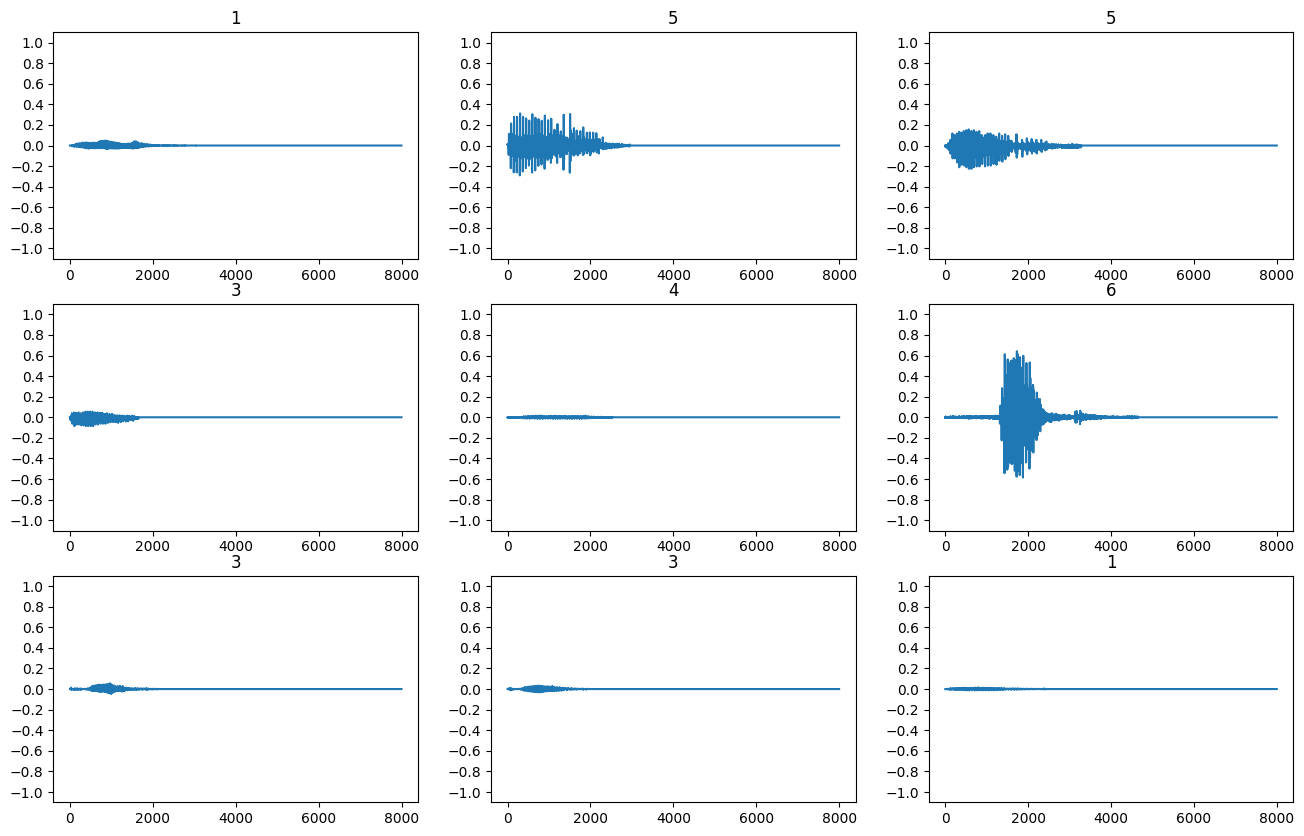

In [42]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

Para el armado de los modelos, es necesario obtener los espectogramas de cada clip de audio, los cuales son una representación visual de la frecuencia del sonido a lo largo del tiempo.

Para ello, creamos la función '**get_spectogram**', la cual realiza una STFT en la onda de audio recibida como parámetro ('*waveform*') dividiendo la señal de tiempo en segmentos y luego calculando la Transformada de Fourier en cada segmento. Luego, se toma el valor absoluto de la STFT, conservando la amplitud. Por último, se añade una dimensión adicional al tensor del espectrograma para que éste tenga la forma adecuada para ser utilizado como entrada en capas de convolución.

In [43]:
def get_spectrogram(waveform):
  '''Transforma una onda de audio en un espectograma'''
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) # convertir la onda de audio a un espectograma mediante una STFT
  spectrogram = tf.abs(spectrogram) # obtenemos la magnitud del STFT
  spectrogram = spectrogram[..., tf.newaxis] # agregamos una dimensión adicional
  return spectrogram

A modo de ejemplo, mostramos tres clips del dataset. Vemos la case a la que pertenece, la dimensión de la forma de onda, las dimensiones del espectograma y una muestra reproducible del clip en cuestión.

In [44]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))

Label: 1
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 5
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 5
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


A continuación, definimos la función '**plot_spectogram**' con el fin de mostrar gráficamente el espectograma de un clip.

In [45]:
def plot_spectrogram(spectrogram, ax):
  '''Grafica un espectrograma'''
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Exception ignored in: <function _xla_gc_callback at 0x7e64f37f8790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


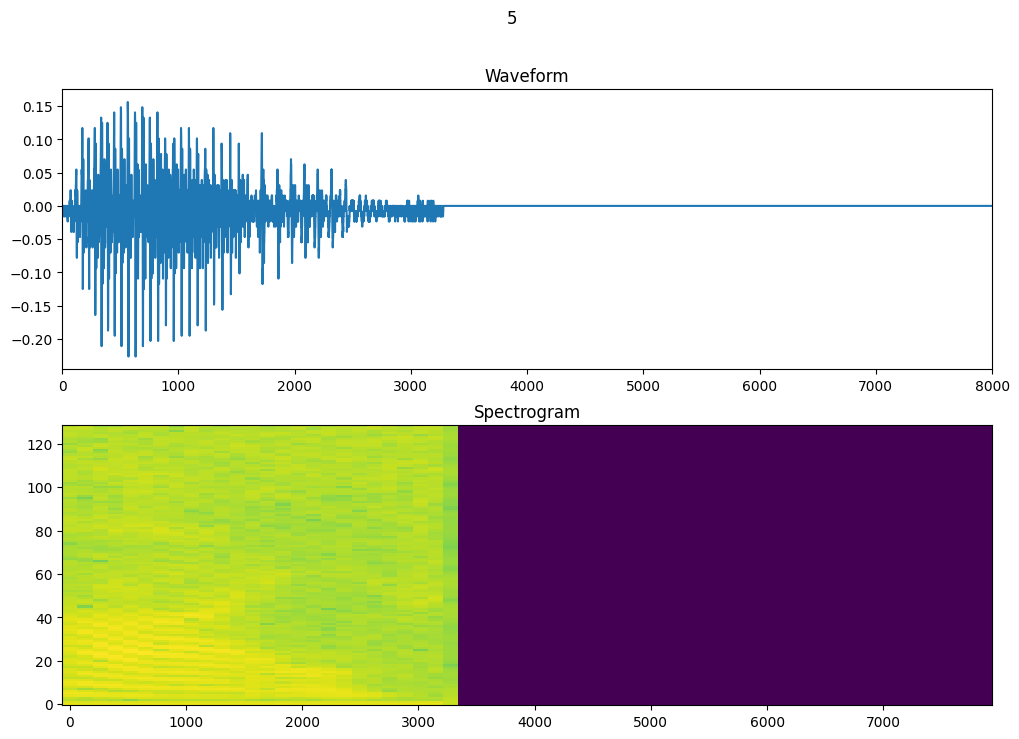

In [46]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Luego, como nos interesa obtener los espectogramas de todos los clips de audio del dataset para el entrenamiento de los modelos, definimos la función '**make_spec_ds**', la cual toma un conjunto de datos '*ds*' como entrada y utiliza el método map del conjunto de datos para aplicar una función de mapeo a cada elemento del conjunto de datos, la cual toma un par (audio, label) y devuelve un par (espectrograma, label), donde espectrograma es el resultado de aplicar la función '**get_spectrogram**' anteriormente definida al audio.

In [47]:
def make_spec_ds(ds):
  '''Obtiene los espectogramas de cada clip'''
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds) # obtenemos espectogramas del conjunto de entrenamiento
val_spectrogram_ds = make_spec_ds(val_ds) # obtenemos espectogramas del conjunto de validación

A modo de ejemplo, tomamos el primer batch del conjunto de entrenamiento y mostramos sus espectogramas

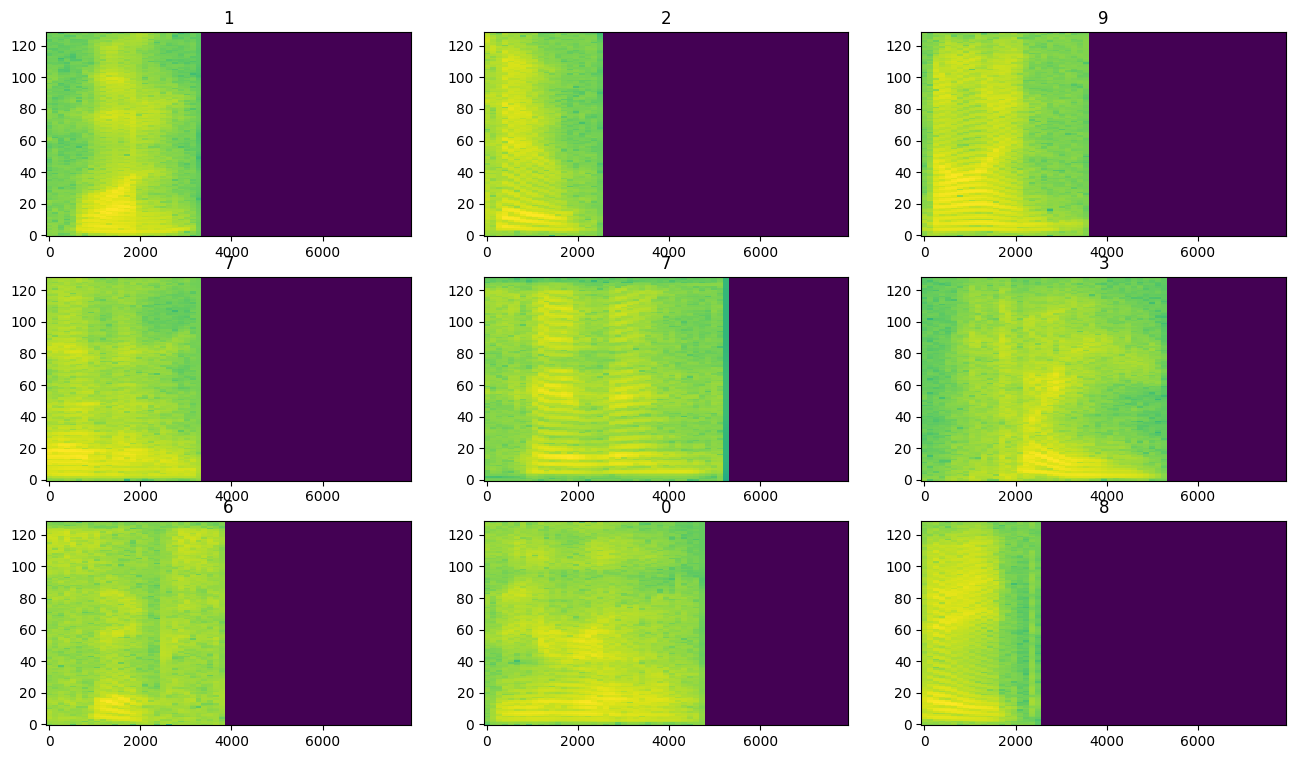

In [48]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Red neuronal convolucional

En esta sección entrenaremos un modelo de red neuronal convolucional para clasificar los clips de audio en clases del 0 al 9.

Primero, optimizaremos los conjuntos de datos de entrenamiento y validación para mejorar la eficiencia del entrenamiento del modelo. Además, mostramos las dimensiones de los datos de entrada.

In [16]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

Input shape: (61, 129, 1)


Probaremos primero el modelo de redes convolucionales del lab 11, utilizando TensorFlow y Keras para procesar espectrogramas.

Primero, definimos una capa de normalización para estandarizar los espectrogramas. Luego, construimos un modelo secuencial con las siguientes capas: redimensionamiento de los espectrogramas en 32x32, normalización, algunas capas convolucionales para extraer características, una capa de max pooling para reducir la dimensionalidad, y una capa densa de 128 neuronas con activación relu y dropout de 0.5 para prevenir el overfitting.







In [17]:
norm_layer = layers.Normalization() # capa de normalización
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec)) # normalizamos los espectrogramas

modelo_1 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), # redimensionamos a 32x32
    norm_layer, # normalizamos
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),  # maxpooling
    layers.Dropout(0.25), # dropout
    layers.Flatten(),
    layers.Dense(128, activation='relu'), # capa densa
    layers.Dropout(0.5),  # dropout
    layers.Dense(len(label_names)),
])

modelo_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

Configuramos el modelo con el optimizador Adam y entrenamos el modelo con los datos de entrenamiento y validación durante 50 épocas. Además, definimos como callback un EarlyStopping que permitirá que el entrenamiento se detenga de manera anticipada si el accuracy no mejora durante 5 épocas consecutivas.


In [18]:
modelo_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 50
history_1 = modelo_1.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
38/38 [==============================] - 25s 528ms/step - loss: 1.8362 - accuracy: 0.3887 - val_loss: 1.2100 - val_accuracy: 0.6733
Epoch 2/50
38/38 [==============================] - 10s 277ms/step - loss: 1.1826 - accuracy: 0.6079 - val_loss: 0.8371 - val_accuracy: 0.7733
Epoch 3/50
38/38 [==============================] - 9s 228ms/step - loss: 0.8345 - accuracy: 0.7287 - val_loss: 0.5858 - val_accuracy: 0.8333
Epoch 4/50
38/38 [==============================] - 7s 197ms/step - loss: 0.6508 - accuracy: 0.7942 - val_loss: 0.4485 - val_accuracy: 0.8917
Epoch 5/50
38/38 [==============================] - 9s 244ms/step - loss: 0.5181 - accuracy: 0.8317 - val_loss: 0.3887 - val_accuracy: 0.8933
Epoch 6/50
38/38 [==============================] - 9s 249ms/step - loss: 0.4267 - accuracy: 0.8683 - val_loss: 0.3242 - val_accuracy: 0.9217
Epoch 7/50
38/38 [==============================] - 7s 196ms/step - loss: 0.3646 - accuracy: 0.8813 - val_loss: 0.2510 - val_accuracy: 0.9317
Epoc

Finalmente, definimos dos funciones que nos muestran los resultados del modelo. La primera, '**mostrar_reporte**' imprime las métricas resultantes del entrenamiento para clase y un mapa de calor para interpretar visualmente el resultado.

1/1 [==============================] - 0s 117ms/step
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.98      0.94      0.96        52
           2       0.97      0.99      0.98        69
           3       0.94      0.97      0.95        60
           4       1.00      1.00      1.00        69
           5       0.98      0.98      0.98        55
           6       1.00      0.93      0.96        68
           7       1.00      0.97      0.98        59
           8       0.93      1.00      0.96        54
           9       0.95      0.98      0.97        62

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



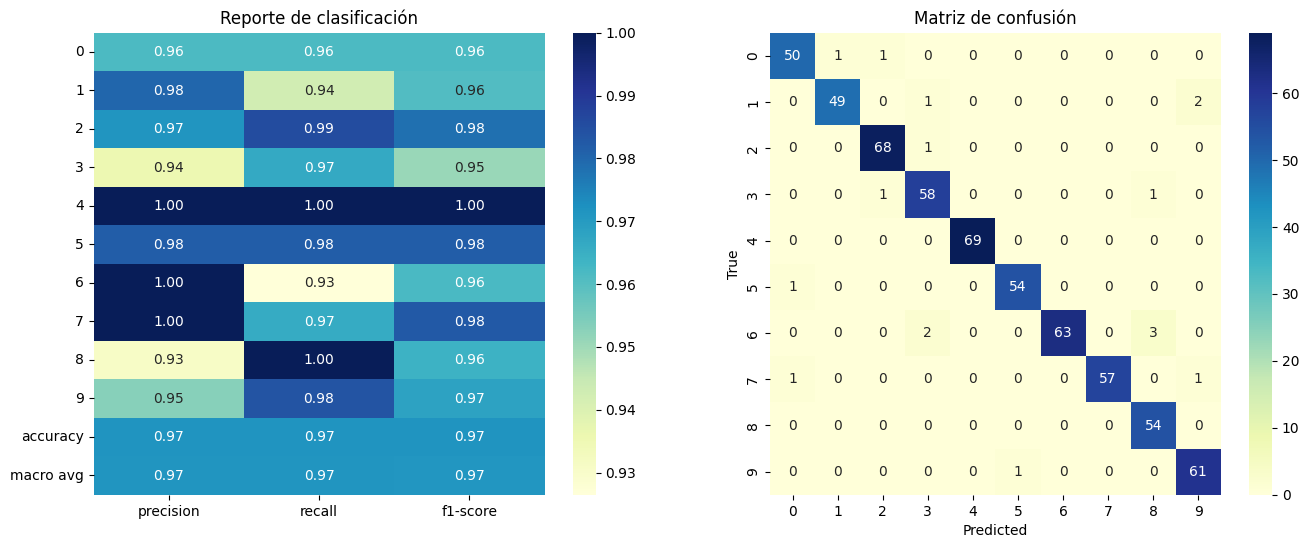

In [20]:
def mostrar_reporte(model, val_data, class_names):
    '''Muestra el reporte de clasificación y el mapa de calor de algunas métricas junto con una matriz de confusión'''
    val_labels = []
    val_preds = []
    for audio, labels in val_data:
        preds = model.predict(audio)
        val_labels.extend(labels.numpy())
        val_preds.extend(np.argmax(preds, axis=1))

    report = classification_report(val_labels, val_preds, target_names=class_names, output_dict=True) # métricas por clase
    report_df = pd.DataFrame(report).transpose()

    print("Reporte de clasificación:\n", classification_report(val_labels, val_preds, target_names=class_names))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Mapa de calor del reporte de clasificación
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt='.2f', ax=axes[0])
    axes[0].set_title('Reporte de clasificación')

    # Matriz de confusión
    cm = confusion_matrix(val_labels, val_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Matriz de confusión')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.show()

class_names = label_names.tolist()
mostrar_reporte(modelo_1, val_spectrogram_ds, class_names)

El modelo de clasificación entrenado muestra un rendimiento bastante robusto con una precisión promedio del 97% en el conjunto de datos de prueba.

Se observa un alto nivel de precisión, recall y f1-score en todas las clases. Esto indica que el modelo es robusto y capaz de clasificar con alta confianza la mayoría de las muestras de cada clase, con pocas discrepancias de precisiones por clase.

Podemos concluir entonces que el modelo tiene un desempeño bastante equilibrado entre las clases y es preciso.

Finalmente, veamos la evolución de la pérdida y el accuracy a lo largo del entrenamiento con la funcion '**evolucion_loss_accuracy**'.

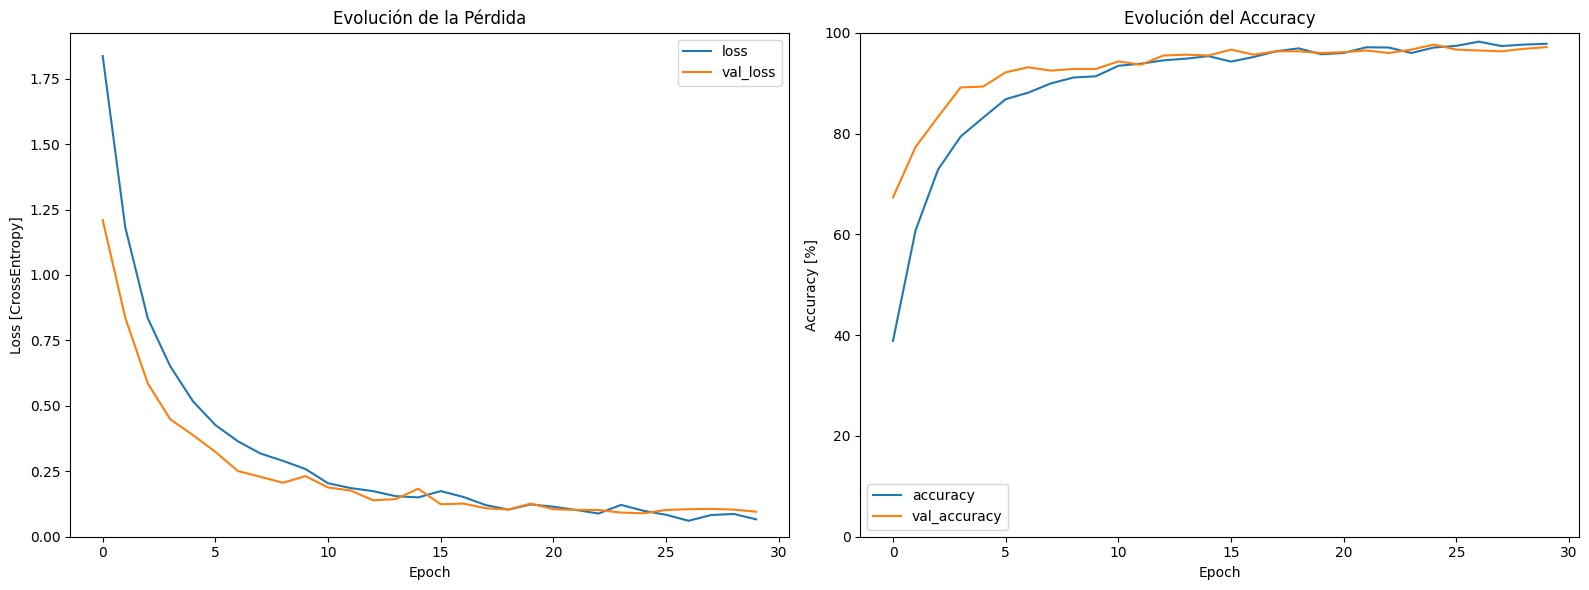

In [21]:
def evolucion_loss_accuracy(history):
    '''Muestra la evolución de la pérdida y el accuracy durante el entrenamiento'''
    metrics = history.history
    plt.figure(figsize=(16,6))

    # gráfico de la pérdida
    plt.subplot(1,2,1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')
    plt.title('Evolución de la Pérdida')

    # gráfico del accuracy
    plt.subplot(1,2,2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.title('Evolución del Accuracy')

    plt.tight_layout()
    plt.show()


evolucion_loss_accuracy(history_1)

Los gráficos muestran el rendimiento del modelo durante el entrenamiento a lo largo de las épocas. Se observa que el modelo parece converger alrededor de la época 20, lo cual es relativamente temprano considerando que se configuraron 50 épocas inicialmente.

## Modelo 2

A continuación, probaremos un segundo modelo con una arquitectura más compleja. En este caso, incrementamos el número de neuronas en todas las capas y añadimos una capa densa adicional. También experimentamos con otros porcentajes de dropout.

In [22]:
modelo_2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), # redimensionamos a 32x32
    norm_layer, # normalizamos
    layers.Conv2D(40, 3, activation='relu'),
    layers.Conv2D(120, 3, activation='relu'),
    layers.MaxPooling2D(),  # maxpooling
    layers.Dropout(0.25), # dropout
    layers.Flatten(),
    layers.Dense(128, activation='relu'), # capa densa
    layers.Dropout(0.25),  # dropout
    layers.Dense(64, activation='relu'), # capa densa
    layers.Dropout(0.4),  # dropout
    layers.Dense(len(label_names))
])

modelo_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 40)        400       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 120)       43320     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 120)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 120)      

Compilamos el modelo con los mismos parámetros que antes, pero hemos aumentado el valor del parámetro '*patience*' en EarlyStopping. Esto se debe a que observamos que en la mayoría de los casos, el entrenamiento se detenía muy pronto.

In [23]:
modelo_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 50
history_2 = modelo_2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
)

Epoch 1/50
38/38 [==============================] - 18s 449ms/step - loss: 2.0215 - accuracy: 0.2829 - val_loss: 1.4110 - val_accuracy: 0.5800
Epoch 2/50
38/38 [==============================] - 16s 426ms/step - loss: 1.4771 - accuracy: 0.4975 - val_loss: 1.0003 - val_accuracy: 0.7333
Epoch 3/50
38/38 [==============================] - 17s 440ms/step - loss: 1.0604 - accuracy: 0.6413 - val_loss: 0.6630 - val_accuracy: 0.8433
Epoch 4/50
38/38 [==============================] - 16s 435ms/step - loss: 0.8029 - accuracy: 0.7279 - val_loss: 0.4728 - val_accuracy: 0.8767
Epoch 5/50
38/38 [==============================] - 16s 428ms/step - loss: 0.5605 - accuracy: 0.8246 - val_loss: 0.3213 - val_accuracy: 0.9100
Epoch 6/50
38/38 [==============================] - 17s 439ms/step - loss: 0.4537 - accuracy: 0.8542 - val_loss: 0.2594 - val_accuracy: 0.9367
Epoch 7/50
38/38 [==============================] - 18s 483ms/step - loss: 0.3643 - accuracy: 0.8908 - val_loss: 0.2016 - val_accuracy: 0.9517

El entrenamiento se detuvo en la época 43 porque no se evidenciaban mejoras en el accuracy. Mostramos, en la siguiente celda, el reporte de clasificación y su mapa de calor. Además, una matriz de confusión.

1/1 [==============================] - 0s 154ms/step
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       1.00      0.92      0.96        52
           2       0.99      0.99      0.99        69
           3       0.92      0.98      0.95        60
           4       1.00      1.00      1.00        69
           5       0.96      0.98      0.97        55
           6       1.00      0.91      0.95        68
           7       0.98      0.98      0.98        59
           8       0.95      1.00      0.97        54
           9       0.95      0.98      0.97        62

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



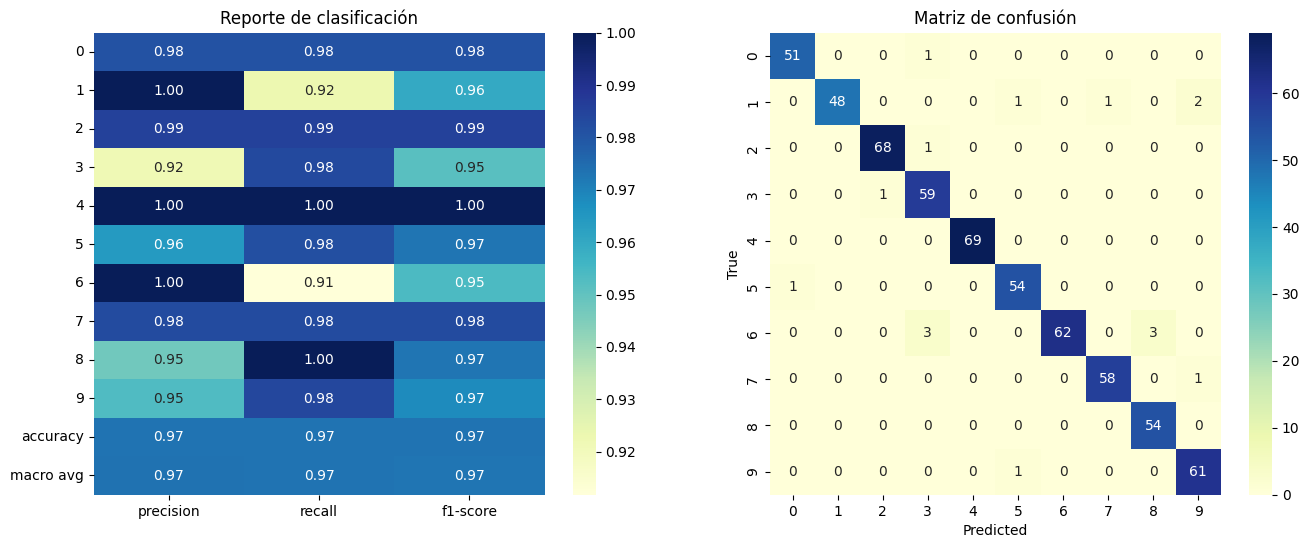

In [24]:
mostrar_reporte(modelo_2, val_spectrogram_ds, class_names)

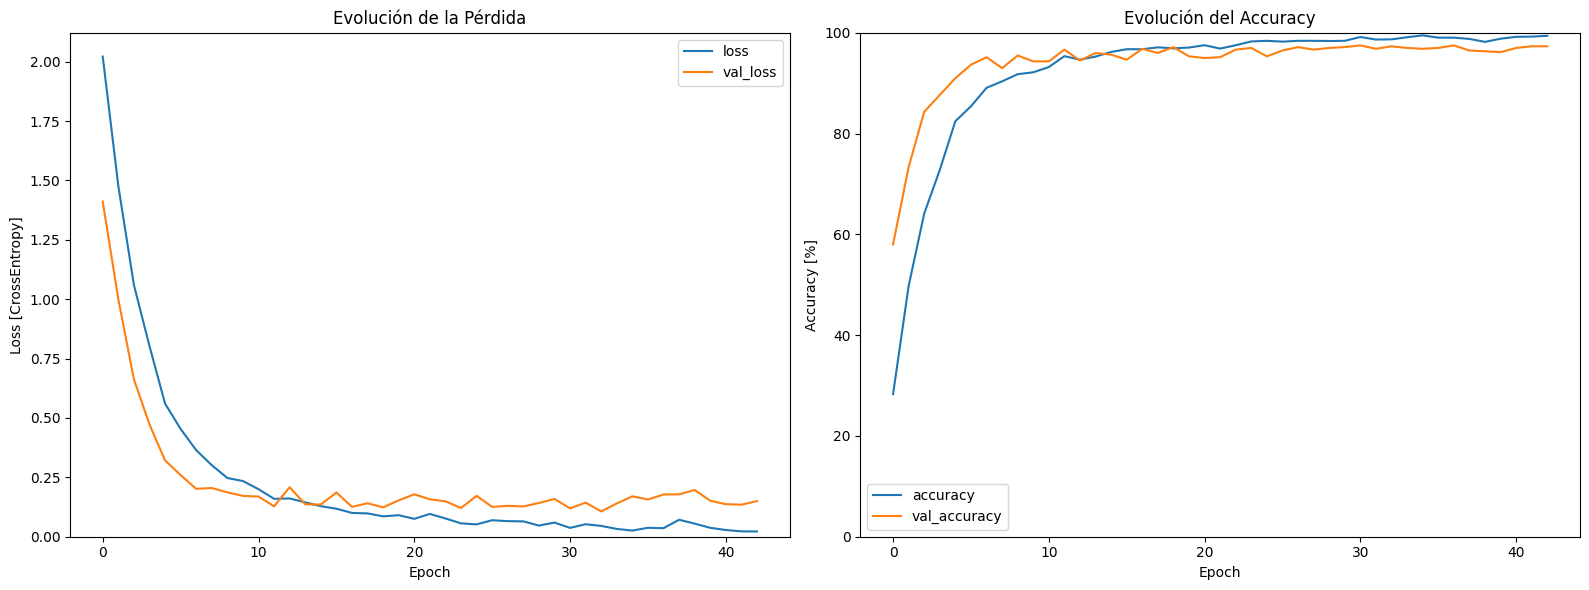

In [25]:
evolucion_loss_accuracy(history_2)

El reporte de clasificación de este segundo modelo presenta métricas muy similares al anterior, con un accuracy global del 97% en el conjunto de prueba. Se observa un alto nivel de precisión, recall y f1-score en la mayoría de las clases.

Comparado con el modelo anterior, las diferencias son mínimas y probablemente se atribuyan a variaciones aleatorias en el entrenamiento. Ambos modelos muestran un rendimiento excepcional, con f1-scores en la mayoría de las clases por encima del 0.95 y un accuracy promedio de 0.97.

# Red neuronal recurrente

En esta sección, entrenaremos un modelo de red neuronal recurrente. Anteriormente, añadimos un canal extra a los espectrogramas para que pudieran ser utilizados como datos de entrada en una red neuronal convolucional, como se muestra en el resultado de la siguiente celda de código.

In [49]:
print('Spectrogram shape:', spectrogram.shape)

Spectrogram shape: (61, 129, 1)


Sin embargo, para entrenar una red neuronal recurrente, necesitaremos aplanar los datos, eliminando el último canal agregado. Para ello, modificaremos las dimensiones de la entrada en la primera línea al definir el modelo.

In [54]:
modelo_recurrente = models.Sequential([
    layers.Input(shape=(61, 129)),  # ajustamos la dimensión de entrada
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(64),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_names), activation='softmax')
])

modelo_recurrente.summary()


modelo_recurrente.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


EPOCHS = 100
history_recurrente = modelo_recurrente.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10)
)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 61, 64)            49664     
                                                                 
 dropout_20 (Dropout)        (None, 61, 64)            0         
                                                                 
 lstm_16 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 10)                650       
                                                                 
Total params: 87498 (341.79 KB)
Trainable params: 874

1/1 [==============================] - 1s 942ms/step
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        52
           1       0.98      0.94      0.96        52
           2       0.98      0.94      0.96        69
           3       0.90      0.87      0.88        60
           4       0.99      1.00      0.99        69
           5       0.96      0.96      0.96        55
           6       0.92      0.87      0.89        68
           7       1.00      0.97      0.98        59
           8       0.87      1.00      0.93        54
           9       0.97      0.98      0.98        62

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



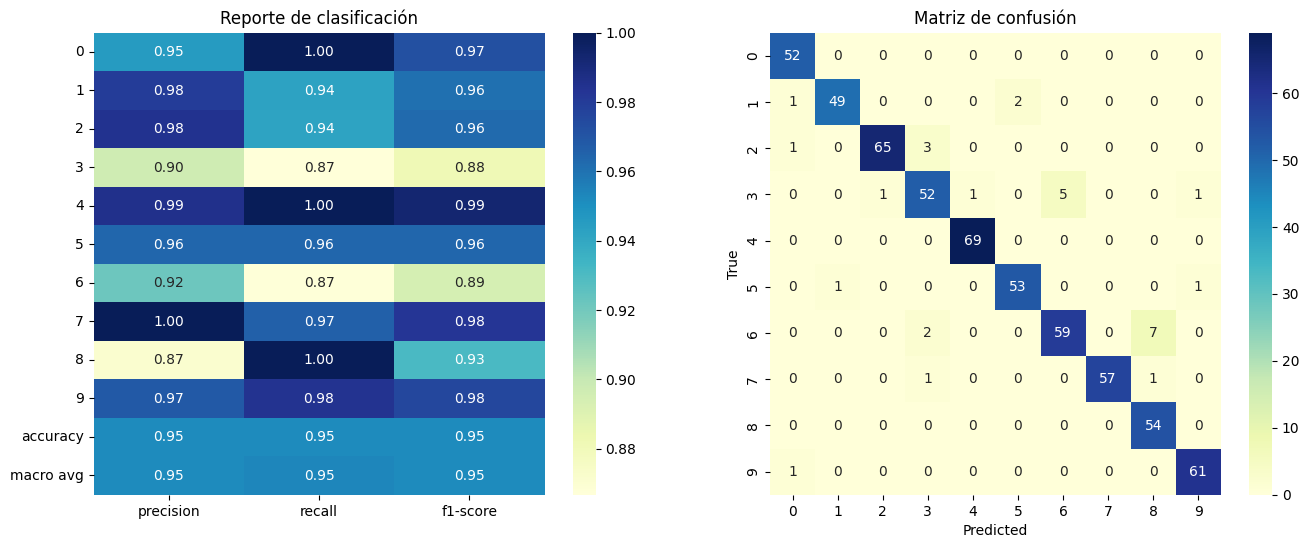

In [56]:
mostrar_reporte(modelo_recurrente, val_spectrogram_ds, class_names)

Los resultados del modelo de red neuronal recurrente muestran un desempeño muy bueno, con un promedio de aproximadamente 95% en accuracy. Respecto a los entrenamientos anteriores, se observa que, por muy poco, este modelo no alcanza la eficiencia observada. Algunas clases tienen excelente buen desempeño, como la clase 4, pero otras clases muestran resultados más bajos, como la clase 6.

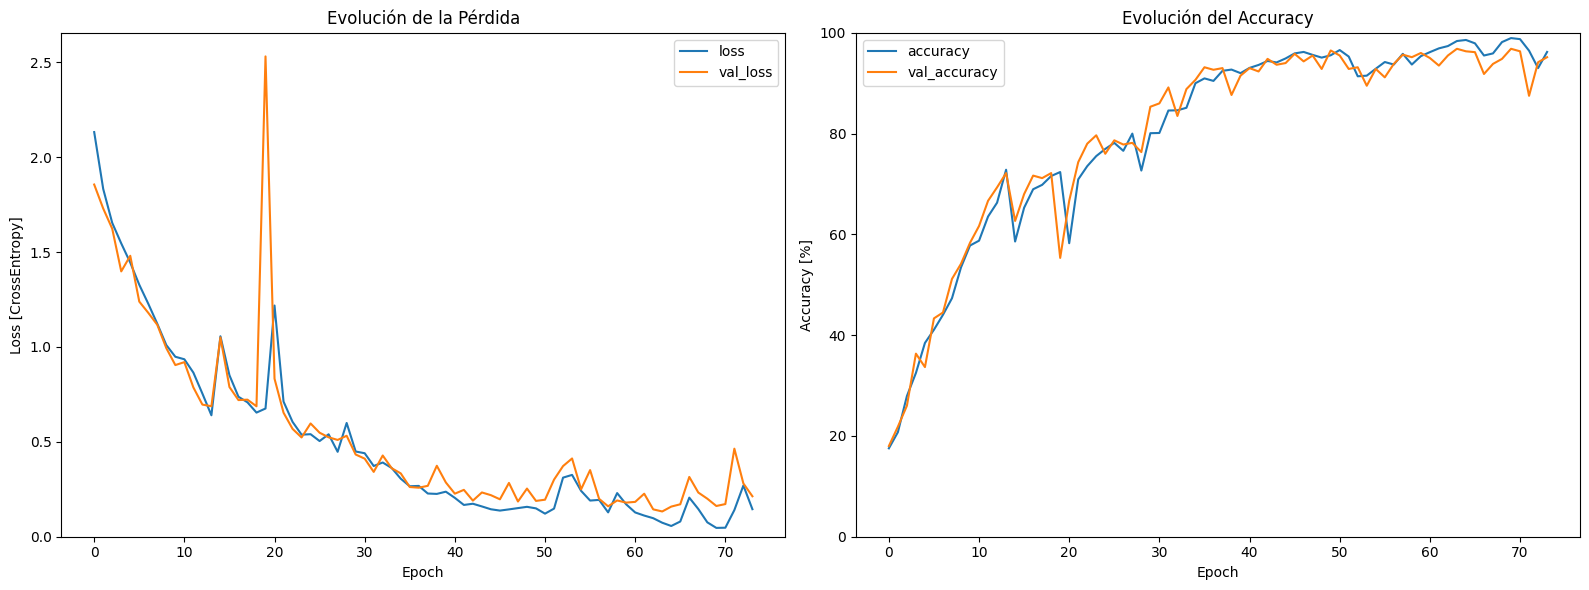

In [55]:
evolucion_loss_accuracy(history_recurrente)

# Conclusiones

En este ejercicio del trabajo práctico, creamos modelos de redes neuronales convolucionales y recurrentes para la resolución del problema de clasificación de digitos hablados.

Comenzamos procesando los datos organizándolos en carpetas según la clase a la que pertenecen, visualizando sus formas de onda de audio y generando sus espectogramas. Luego, dividimos el dataset en conjuntos de entrenamiento y prueba para comenzar a crear los modelos de redes neuronales.

Inicialmente, probamos dos arquitecturas diferentes de redes neuronales convolucionales. Dado que tratamos los espectrogramas de audio como imágenes, fue crucial agregar un canal adicional para cada espectrograma, requerido por la arquitectura convolucional. Ambos modelos alcanzaron resultados sobresalientes, con métricas cercanas a 1. Esto indica que los modelos convolucionales son altamente efectivos para este tipo de problemas, al menos con este dataset específico.

Posteriormente, entrenamos un modelo de red neuronal recurrente, un tipo de red que aprendimos en clase. Aquí, adaptamos nuevamente los datos, eliminando el canal extra agregado para las redes convolucionales. Los resultados fueron, en general, muy buenos. Sin embargo, no alcanzaron la precisión de los anteriores.

Si bien hemos probado distintas arquitecturas que no agregamos en el trabajo ya que los resultados eran extremendamente similares, es probable que si se seleccionan mejores hiperparámetros, como número de capas, neuronas, dropout, entre otros, se puedan obtener aún mejores resultados, alcanzando o superando los obtenidos a partir de las redes convoluciones.

En conclusión, para este problema en particular, se observó que los modelos de redes convolucionales brindaron mejores resultados, dando solución al problema de clasificación con una precisión de 0.97%.